# Convolutional Neural Network (CNN)

`
Convolutional Neural Networks (ConvNets or CNNs) are a category of Neural Networks proven effective in image recognition and classification. ConvNets have been successful in identifying faces, objects and traffic signs apart from powering vision in robots and self-driving cars.
`

More details in the link: https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/

## Introduction

In this lab, we will build a Convolutional Neural Network to automatically detecting P and S phases in the seismic waveforms. This lab is modified from study entitled ["Generalized Seismic Phase Detection with Deep Learning" by Zachary E. Ross et al., 2019](https://arxiv.org/abs/1805.01075)

The training dataset are provided in the Waveform.npy and Label.npy. The waveforms (X) are composed of three components (N,E,Z) with the window length of 4 seconds. The sampling rate is 100 Hz. Therefore, for each training seismgram, there are 400*3 data points. The Labels (Y) distinguish 3 classes (P,S, and Noise windows) with 3 numbers (0,1,2). In order to perform multiple classification by CNN, we need to do one-hot encoding for the labels. The link of why we need one-hot encoding is attached: https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/. By using one-hot encoding we change the labels 0,1,and 2 into [1,0,0],[0,1,0],and[0,0,1] 

We then split the training dataset into two parts: one for training, one for testing. We use the testing dataset to select best model. To measure the performance of best trained model, we plot the [confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/#:~:text=A%20confusion%20matrix%20is%20a,related%20terminology%20can%20be%20confusing.), [precision-recall curve](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html) and [ROC curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5).

#### Notice

If you meet a bug from Keras packages (version problem), please try to change the import source.   
For example, you can switch `from keras.layers import Conv1D`  to `from tensorflow.keras.layers import Conv1D`


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
from obspy.signal.trigger import trigger_onset

# sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve

# keras packages
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D,Flatten,Dense,Dropout,BatchNormalization
from keras.utils import np_utils
from keras.optimizers import Adam

/Users/tianfeng/anaconda3/lib/python3.6/site-packages/obspy/signal/headers.py:93: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ], align=True)
Using TensorFlow backend.


## Read Data 

Load waveform (X) and label (Y) dataset from Southern California Earthquake Data Center http://scedc.caltech.edu/research-tools/deeplearning.html. The dataset used in this labe includes 10000 samples (1% of total dataset). The following section plot 3 examples of P/S waves and Noise windows. The window length are all 4 seconds with sampling rate of 100 Hz. The P and S wave arrivals occurs at the center of the windows. 

In order to perform multiple classification with CNN, we need to do one-hot encoding for the labels [[link]](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/). By using one-hot encoding we change the labels 0,1,and 2 into [1,0,0],[0,1,0],and[0,0,1] respectively. We use [1,0,0],[0,1,0],and[0,0,1] to represent P phase, noise, and S pahse respectively.


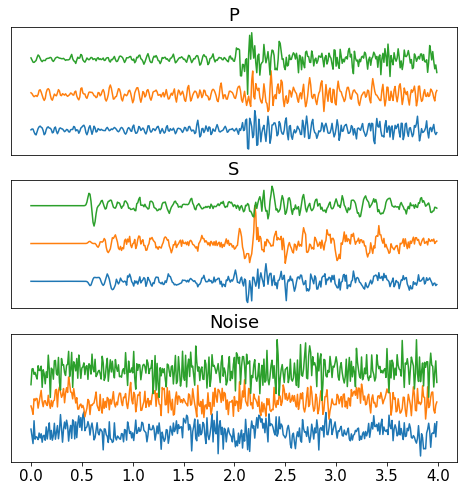

In [2]:
X=np.load('Waveform.npy')
Y=np.load('Label.npy')
labels=['P','S','Noise']

# Plot examples of 3 classes
matplotlib.rc('font', **{'size'   : 15})

order=[0,2,1]
plt.figure(figsize=(8,8))
for k in range(3):
    plt.subplot(3,1,k+1)
    for i in range(3):
        plt.plot(np.arange(400)*0.01,X[order[k],:,i]+i)
    plt.title(labels[k])
    plt.yticks([])
    if k<2:
        plt.xticks([])
plt.show()


# convert integers to dummy variables (one hot encoding)
encoder = LabelEncoder()
encoded_Y = encoder.fit_transform(Y)
en_Y = np_utils.to_categorical(encoded_Y)

# split dataset into training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X, en_Y, test_size=0.33, random_state=42)


## Building the Model

Training a convolutional nerual network is similar to training a (fully-connected) nerual network. You can find the definition of loss function, optimizer, activation functions, epoch and batch size in the lab of nerual network. 

The largest difference between CNN and NN is that CNN use layers called Conv1D or Conv2D. In our lab, waveforms are time series not a 2D images. So we use the [Conv1D](https://keras.io/api/layers/convolution_layers/convolution1d/). The first argument for Conv1D is the number of filters. It means the dimensionality of the output space (i.e. the number of output filters in the convolution). It must be a integer. The second argument is kernel size. It specifies the length of the 1D convolution window. Another important argument is strides, specifying the stride length of the convolution. It means the downsampling rate, if you set stride equals 2, the output time series would downsample by 2. It has similar effect as [pooling layers](https://keras.io/api/layers/pooling_layers/max_pooling1d/). The first layer is very special, you need to define the input shape (input_shape). In our case the shape of input is 400*3. The window length of a recording of waveform is 4 seconds and the sampling rate is 100 Hz. So we had 400 points for a waveform recording. The number 3 means the number of channels (N,E,Z).

We usually use relu function for the activation functions in the Conv1D and Dense layers, however, for the last layer, we should use softmax. The softmax function takes the output vector, and scales all values such that they sum up to 1. In this way, we get a vector of probabilities. The first entry in the output corresponds to the probability that the input image is a 0, the second entry that the input is 1, etc.:

$$
P = \left[\begin{matrix} p(0) \\ p(1) \\ p(2) \\ ... \\ p(9) \end{matrix} \right] \quad , \quad \sum_{i=0}^9 P_i = 1
$$

We now have to choose a loss function. For multi-class classification tasks, _categorical cross-entropy_ is usually a good choice. This loss function is defined as follows:

$$
\mathcal{L} = - \sum_{c=0}^N y_c \log \left( p_c \right)
$$

where $y_c$ is the label of class $c$, and $p$ is the predicted probability. Note that $y_c$ is either 0 or 1, and that $0 < p_c < 1$. With our chosen loss function, we are ready for the final assembly of the model.

In addition, we add Dropout. You can learn more about it if you are interested. [Dropout](https://towardsdatascience.com/machine-learning-part-20-dropout-keras-layers-explained-8c9f6dc4c9ab) is a technique used to prevent a model from overfitting. Dropout works by randomly setting the outgoing edges of hidden units (neurons that make up hidden layers) to 0 at each update of the training phase.

We build the model with the following code:
```
model = Sequential()
model.add(Conv1D(16, 3, activation='relu',strides=2,input_shape=(n_in,3)))
model.add(Conv1D(32, 3, strides=2,activation='relu'))
model.add(Conv1D(64, 3, strides=2,activation='relu'))
model.add(Conv1D(128, 3, strides=2,activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
```
The model structure is shown below:

![image](./Fig/phase_model.png)



In [3]:
# 3 classes
n_in=400
model = Sequential()
# add convolutional layers
model.add(Conv1D(16, 3, activation='relu',strides=2,input_shape=(n_in,3)))
model.add(Conv1D(32, 3, strides=2,activation='relu'))
model.add(Conv1D(64, 3, strides=2,activation='relu'))
model.add(Conv1D(128, 3, strides=2,activation='relu'))
# Flatten before fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
# Dropout to prevent a model from overfitting. 0.5 means 50% neurals are deactivated.
model.add(Dropout(0.5))
# Softmax is suitable for multiple classification problem
model.add(Dense(3, activation='softmax'))
model.summary()

adam=Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Early stop
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint('CNNclassifier.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
history=model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_val, y_val),
                callbacks=[es,mc], verbose=0)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 199, 16)           160       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 99, 32)            1568      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 49, 64)            6208      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 24, 128)           24704     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               393344    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

## Training History

We have recorded the history of training in a variable named 'history'. We wll then visualize the history of the training/testing loss. In addition to loss, we can plot the metrics change with the training epoch. In the following plots, you can see the training loss would be smaller than testing loss after certain epoch. It means the model starts to overfit after that epoch and we should stop training then.


accuracy: 94.45%


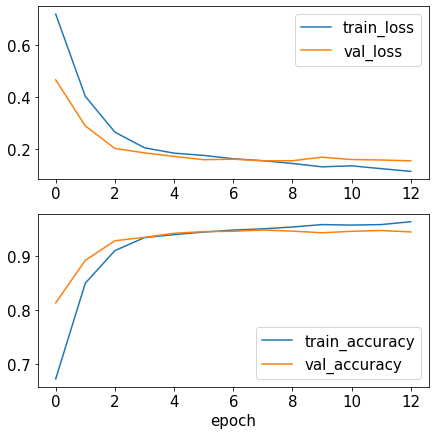

In [5]:
# plot metrics
plt.figure(figsize=(7,7))
plt.subplot(211)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train_loss','val_loss'])
plt.subplot(212)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_accuracy','val_accuracy'])
plt.xlabel('epoch')
scores = model.evaluate(X_val, y_val, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

## [Plotting Confusion Matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/#:~:text=A%20confusion%20matrix%20is%20a,related%20terminology%20can%20be%20confusing.)

In this section, we would plot the confusion matrix. You could learn more about it through the link

[[1048   44   32]
 [  32 1032   21]
 [  27   27 1037]]


Text(0.5, 31.943301820015094, 'Predicted label')

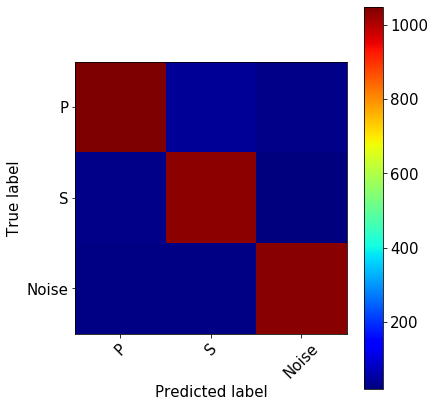

In [6]:
y_pred = model.predict(X_val)
y_val_nonhot=np.round(y_val.argmax(axis=1))
y_pred_nonhot=np.round(y_pred.argmax(axis=1))
cm = confusion_matrix(y_val_nonhot, y_pred_nonhot)
print(cm)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap='jet')
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.ylim([2.5,-0.5])
plt.xlim([-0.5,2.5])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

## [Plotting Precision-Recall Curve](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)

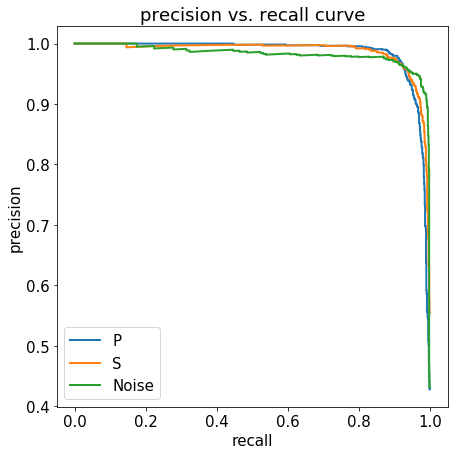

In [7]:
# precision recall curve

plt.figure(figsize=(7,7))
precision = dict()
recall = dict()
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y_val[:, i],y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='{}'.format(labels[i]))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

## [Plotting ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)


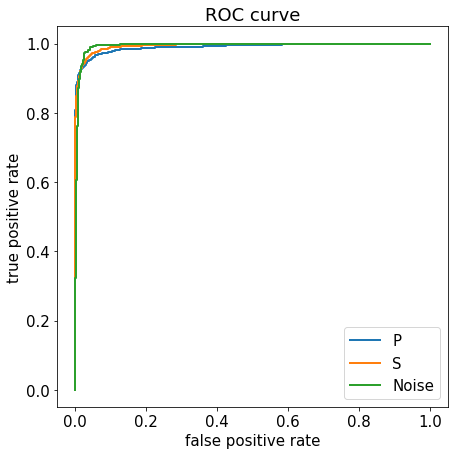

In [8]:
# roc curve
plt.figure(figsize=(7,7))

fpr = dict()
tpr = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred[:, i])
    
    plt.plot(fpr[i], tpr[i], lw=2, label='{}'.format(labels[i]))

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()

## Exercise 1

Please finish training the provided model. Then plot loss/accuracy history curve, confusion matrix, precision-recall curve, and ROC curve. Please use plt.savefig to save these figures and include them in the final reports.

## Exercise 2

Please try 3 additional models and plot corresponding loss/accuracy history curve, confusion matrix, precision-recall curve, and ROC curve.
Please use plt.savefig to save these figures and include them in the final reports.
#### Model 1 (Deeper Structure)
Filter size in all Conv1D layers are 3.
Strides in all Conv1D layers are 2.

![image](Fig/Q_1.png)


#### Model 2 (Change Filter Size)
Filter size in the first Conv1D layer is 7, second layer is 5, and third layer is 3.
Strides in all Conv1D layers are 2.

![image](Fig/Q_2.png)


#### Model 3 (Larger Stride)
Filter size in all Conv1D layers are 3.
Strides in all Conv1D layers are 3.

![image](Fig/Q_3.png)

## Exercise 3

By testing the performance of previous models, you have experiences on how to build a CNN model. Please experiment with different model configurations (number of layers, number of filters, activation functions, number of epochs, etc.) and then use model.summary() function to print the best configuration you used. Please include the summary information in the final report.